In [1]:
import wradlib as wrl
import numpy as np
import matplotlib.pyplot as pl
import datetime as dt

In [2]:
import warnings
warnings.filterwarnings('ignore')

C:\Anaconda\envs\wradlib36_2\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-09-18 14:47:48.698538. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [3]:
fileSUB = './SUB-20120806-171504-02-Z.nc'
fileSUB = './SUB-20140717-040904-02-ZH.nc'

# Part 1: Replicating the error

Note: I skipped the PIA part because for Subic it's not really necessary.

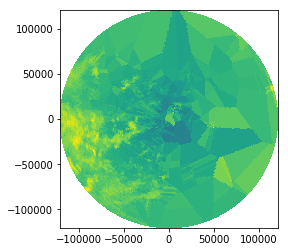

In [17]:
data, attrs = wrl.io.read_edge_netcdf(fileSUB)
time = dt.datetime.strftime(attrs['time'], '%Y%m%d%H%M%S' )
clutter = wrl.clutter.filter_gabella(data, wsize=5, thrsnorain=0., tr1=6., n_p=8., tr2=1.3)
data_no_clutter = wrl.ipol.interpolate_polar(data, clutter)

fig = pl.figure(figsize = (10, 8 ))
ax,pm = wrl.vis.plot_ppi(np.ma.masked_invalid(data_no_clutter), attrs['r'], 
                     az=np.arange(0,360), vmax=50, vmin=-30,
                     cmap=pl.cm.viridis)

# Part 2: Debugging

To figure out what could be wrong in your script, I suggest to plot each step one by one.

(<matplotlib.axes._subplots.AxesSubplot at 0x202a863f60>,
 <matplotlib.collections.QuadMesh at 0x202abed630>)

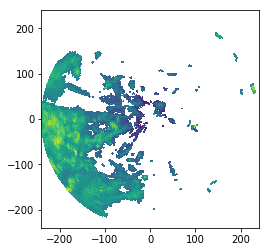

In [19]:
data, attrs = wrl.io.read_edge_netcdf(fileSUB)
wrl.vis.plot_ppi(data)

What can we observe from this?

1. Most of the detected rainfall is at the lower left region.
2. There are pixels that have values of NaN.

Okay, let's see how the clutter filter processes this data.

(<matplotlib.axes._subplots.AxesSubplot at 0x202bd5e668>,
 <matplotlib.collections.QuadMesh at 0x202c1ea828>)

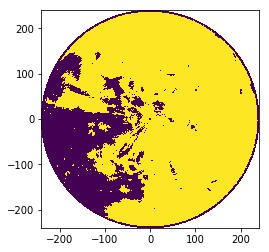

In [21]:
clutter = wrl.clutter.filter_gabella(data, wsize=5, thrsnorain=0., tr1=6., n_p=8., tr2=1.3)

wrl.vis.plot_ppi(clutter)

The clutter filter tags a huge area of the radar coverage as clutter (yellow)---does it make sense? Probably not...

Looking at the interpolated data again:

(<matplotlib.axes._subplots.AxesSubplot at 0x202bd8d978>,
 <matplotlib.collections.QuadMesh at 0x202c666320>)

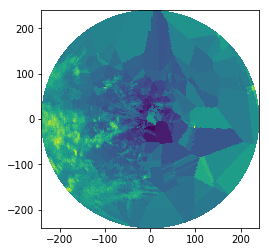

In [22]:
data_no_clutter = wrl.ipol.interpolate_polar(data, clutter)
wrl.vis.plot_ppi(data_no_clutter)

We see that because it's interpolating over such a huge area (over the yellow area), there are weird artifacts in the results. Besides, there are no data in that area, right? So it shouldn't create data where there are none?

# Part 3: Solution

Now we know that the problem arises in the clutter detection step. It cannot handle NaNs, it just assigns it as clutter, which is not very sensible.

To handle that, what we can do is assign a number of the NaN region, but a number that is not within the range of the reflectivities so as not to interfere with calculations. Normally, these regions of no data are assigned with a very large negative number, for example -9999.

In [23]:
data_filled = data.copy()
data_filled[np.isnan(data)] = -9999.

Now let's use this in the clutter filter.

(<matplotlib.axes._subplots.AxesSubplot at 0x202cf31d68>,
 <matplotlib.collections.QuadMesh at 0x202d0ea7b8>)

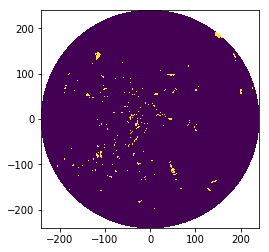

In [27]:
clutter = wrl.clutter.filter_gabella(data_filled, wsize=5, thrsnorain=0., tr1=6., n_p=8., tr2=1.3)

wrl.vis.plot_ppi(clutter)

Okay now the clutter mask makes more sense, as clutter areas are usually small and not covering half of the radar coverage.

Now we can interpolate. 

(<matplotlib.axes._subplots.AxesSubplot at 0x202d0c62b0>,
 <matplotlib.collections.QuadMesh at 0x202d1452b0>)

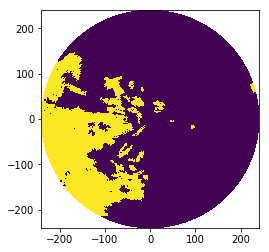

In [28]:
data_no_clutter = wrl.ipol.interpolate_polar(data_filled, clutter)
wrl.vis.plot_ppi(data_no_clutter)

The interpolated data still looks weird, because the dark region has values of -9999 while the rest have normal reflectivity values. We should change the -9999 values back to NaN again to see the data.

(<matplotlib.axes._subplots.AxesSubplot at 0x202c6411d0>,
 <matplotlib.collections.QuadMesh at 0x202d19b390>)

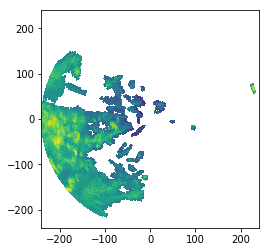

In [29]:
data_no_clutter[np.where(data_no_clutter==-9999.)] = np.nan

wrl.vis.plot_ppi(data_no_clutter)

Now we have the clutter-corrected, interpolated values.